# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Нужно обучить модель классифицировать комментарии на позитивные и негативные. Предоставлен набор данных с разметкой о токсичности правок.

Построить модель со значением метрики качества *F1* не меньше 0.75.

## Подготовка

### Общая информация

In [1]:
# библиотеки
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.pipeline import Pipeline

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Alla\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alla\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# прочитаем файл
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'https://datasets/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [3]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
df.duplicated().sum()

0

In [6]:
# удалим лишний столбец - он дублирует индекс
df = df.drop('Unnamed: 0', axis=1)
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
df['text'] = df['text'].str.lower()

In [8]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

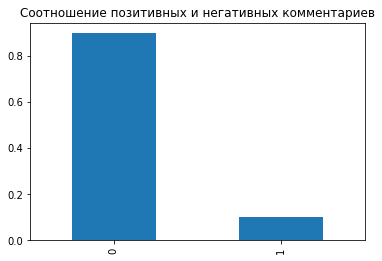

In [9]:
class_frequency = df['toxic'].value_counts(normalize=True)
class_frequency.plot(kind='bar')
plt.title('Соотношение позитивных и негативных комментариев')
plt.show();

**Вывод:** В данных нет пропусков и дубликатов. Удалили лишний столбец. При обучении моделей нужно учесть дисбаланс классов.

### Обработка текста

In [10]:
lemmatizer = WordNetLemmatizer()

In [11]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [12]:
def clear_text(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    word_list = nltk.word_tokenize(text)
    lemmatized_output = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list]
    lemmatized_output = ' '.join(lemmatized_output)
    return lemmatized_output

In [13]:
df['lemm_text'] = df['text'].progress_apply(clear_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [15]:
df.head()

,text,toxic,lemm_text
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,d'aww! he matches this background colour i'm s...,0,daww he match this background colour im seemin...
2,"hey man, i'm really not trying to edit war. it...",0,hey man im really not try to edit war it just ...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i cant make any real suggestion on improv...
4,"you, sir, are my hero. any chance you remember...",0,you sir be my hero any chance you remember wha...


### Признаки

In [25]:
# выделим признаки
target = df['toxic']
features = df['lemm_text']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=12345)

In [26]:
# загрузим список стопслов
stop_words = list(stopwords.words('english'))

# вычислим TF-IDF 
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf_train = count_tf_idf.fit_transform(features_train)
tf_idf_test = count_tf_idf.transform(features_test)

print("Размер матрицы:", tf_idf_train.shape)
print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (143362, 191331)
Размер матрицы: (15930, 191331)


**Вывод:** Сделали лемматизацию и очистили данные от лишних слов и символов. Выделили признаки и вычислили TF-IDF для текстов.

## Обучение

### LogisticRegression

In [29]:
%%time
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ('model', LogisticRegression()),
    ]
)

lr_params_2 = {"model__class_weight":["balanced"],
             "model__C":[10.],
             "model__solver":['lbfgs'], 
             "model__max_iter":[400]
            }

lr_grid_search_2 = GridSearchCV(pipeline, lr_params_2,
                               cv=5, scoring='f1')
lr_grid_search_2.fit(features_train, target_train)
print(lr_grid_search_2.best_params_)
print(lr_grid_search_2.best_score_)

{'model__C': 10.0, 'model__class_weight': 'balanced', 'model__max_iter': 400, 'model__solver': 'lbfgs'}
0.7717702904913905
CPU times: user 8min 37s, sys: 9min 10s, total: 17min 48s
Wall time: 17min 49s


### RandomForest

In [32]:
%%time
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ('model', RandomForestClassifier()),
    ]
)

rf_params_2 = {'model__class_weight':['balanced'],
             'model__max_depth' : [6, 12], 
             'model__n_estimators': [150, 300]
            }

rf_grid_search_2 = GridSearchCV(pipeline, rf_params_2,
                               cv=5, scoring='f1')
rf_grid_search_2.fit(features_train, target_train)
print(rf_grid_search_2.best_params_)
print(rf_grid_search_2.best_score_)

{'model__class_weight': 'balanced', 'model__max_depth': 11, 'model__n_estimators': 200}
0.33972453194466007
CPU times: user 32min 23s, sys: 22.2 s, total: 32min 45s
Wall time: 32min 46s


### Тестирование

In [34]:
# для решения с pipeline
test_pred_2 = lr_grid_search_2.best_estimator_.predict(features_test)
test_score_2 = f1_score(target_test, test_pred_2)
print('F1 тестовой выборки :', test_score_2)

F1 тестовой выборки : 0.7777777777777778


## Выводы

* Был изучен набор данных с разметкой о токсичности правок. Проверен на наличие пропусков и дубликатов.
* Текст очистили от мусора и лемматизировали с помощью Wordnet Lemmatizer с соответствующим POS-тегом.
* В данных выделили признаки и разделиди на обучаюшую и тестовую выборки. Вычислили величину TF-IDF
* Обучили модели Логистической регрессии и Случайного леса. Подобрали к моделям гипперпараметры и выбрали лучшую метрику f1 на них.
* Лучшие результаты соответсвующие условию заказчика показала модель Логистической регрессии с f1 равным 0,76. Модель проверена на тестовой выборке.